In [361]:
import numpy as np
import seaborn as sns
import nltk
import io
import sys
import math
import time
import base64
import warnings
import scipy
import imageio
import kmapper as km
import pandas as pd
import sklearn
from kneed import KneeLocator
import sentence_transformers
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import ks_2samp
from scipy import sparse as sp
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from gensim.models import FastText
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder,LabelBinarizer, OrdinalEncoder,OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from scipy.stats import wasserstein_distance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.scripts.glove2word2vec import glove2word2vec
from torch.utils.data import DataLoader, TensorDataset,Dataset
from sklearn.metrics import silhouette_samples, silhouette_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from hdbscan import HDBSCAN
warnings.filterwarnings("ignore")

In [362]:
sns.set_style('whitegrid')

In [363]:
# Load unlabeled data
df_unlabeled = pd.read_csv('../data/adr_filtered.csv')

In [364]:
df_unlabeled.head()

Unnamed: 0                                               text
0           0  admission date:  [**2120-9-20**]              ...
1           1  admission date:  [**2200-6-1**]              d...
2           2  admission date:  [**2177-6-5**]              d...
3           3  admission date:  [**2112-7-2**]              d...
4           4  admission date:  [**2102-5-15**]     discharge...

In [365]:
df_unlabeled.shape

(5526, 2)

In [366]:
df_unlabeled = df_unlabeled.drop(['Unnamed: 0'], axis=1)

In [367]:
df_unlabeled.head()

text
0  admission date:  [**2120-9-20**]              ...
1  admission date:  [**2200-6-1**]              d...
2  admission date:  [**2177-6-5**]              d...
3  admission date:  [**2112-7-2**]              d...
4  admission date:  [**2102-5-15**]     discharge...

In [368]:
df_unlabeled = df_unlabeled.iloc[:5000]

In [369]:
df_unlabeled.shape

(5000, 1)

In [473]:
df_unlabeled.head()

text
0  admission date:  [**2120-9-20**]              ...
1  admission date:  [**2200-6-1**]              d...
2  admission date:  [**2177-6-5**]              d...
3  admission date:  [**2112-7-2**]              d...
4  admission date:  [**2102-5-15**]     discharge...

In [474]:
# get rid of punctuation
all_text_unlabeled = '\**'.join([c for c in df_unlabeled['text'] if c not in punctuation])

In [475]:
text_unlabeled = [txt for txt in all_text_unlabeled.split('\**') if txt != '']

In [476]:
len(text_unlabeled)

5000

In [477]:
text_unlabeled[:5] 

['admission date:  [**2120-9-20**]              discharge date:   [**2120-9-30**]\n\ndate of birth:  [**2075-5-1**]             sex:   f\n\nservice: medicine\n\nallergies:\nno known allergies / adverse drug reactions\n\nattending:[**first name3 (lf) 3958**]\nchief complaint:\npresyncope\n\nmajor surgical or invasive procedure:\npericardial window\n\nhistory of present illness:\nthis is a 45 y/o female with past medical history of\nhypothyroidism presenting initially for an urgent care visit\nwith an episode of  diaphoresis and presyncope several hours\nprior.  the patient has had ~1 month of bilateral neck\ndiscomfort associated with mild dyspnea on exertion.  her neck\npain improved with physical therapy and her neck pain improved.\nshe now reports worsening doe and worsening neck pain over the\npast 1 1/2 weeks. she now has difficulty walking up a single\nflight of stairs.  additionally, she reports that for the past\nfew days, she hasn\'t been "feeling herself", with fatigue,\nnause

In [480]:
# Save to a plain text file
with open("../data/formatted_inputs_for_sbert.txt", "w", encoding="utf-8") as txt_file:
    for i, sentence in enumerate(text_unlabeled):
        txt_file.write(f"Example {i+1}:\n{sentence}\n\n")

In [483]:
# import csv
# with open("../data/formatted_inputs_for_sbert.csv", "w", encoding="utf-8", newline='') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerow(["Example Number", "Formatted Text"])
#     for i, sentence in enumerate(text_unlabeled):
#         writer.writerow([i + 1, sentence])

In [374]:
model = SentenceTransformer('all-mpnet-base-v2')
#sentences = ['The quick brown fox jumps over the lazy dog', 'Dogs are a popular household pet around the world']

In [375]:
features_array_unlabeled = model.encode(text_unlabeled)

In [376]:
features_array_unlabeled

array([[ 0.03882807,  0.04002392,  0.02975998, ...,  0.02465089,
        -0.05246397, -0.04617011],
       [ 0.04248019, -0.04352849,  0.02456058, ...,  0.00939912,
        -0.03707819, -0.0365523 ],
       [ 0.06029376,  0.00186555,  0.00386006, ...,  0.03257018,
        -0.05022969, -0.0479512 ],
       ...,
       [-0.01115894, -0.05839727,  0.00653473, ..., -0.00890203,
        -0.0397311 , -0.03686926],
       [-0.0016725 , -0.03332345,  0.00014142, ...,  0.06566262,
         0.01091151, -0.03218708],
       [ 0.03488145, -0.02456742,  0.01389765, ..., -0.0045754 ,
        -0.02064873, -0.03929618]], dtype=float32)

In [377]:
features_array_unlabeled.shape

(5000, 768)

#### Process Unlabeled Data

In [378]:
sc = StandardScaler()

In [379]:
pca = PCA(n_components=2,random_state=100)

In [380]:
features_array_unlabeled.shape

(5000, 768)

In [381]:
features_scaled_unlabeled = sc.fit_transform(features_array_unlabeled)

In [382]:
features_array_pca_unlabeled = pca.fit_transform(features_scaled_unlabeled)

In [383]:
# Create 2 components using t-SNE(t-Stochastic Neighbor Embedding)
tsne = TSNE(n_components=2, perplexity=30,learning_rate='auto', n_iter=300)

In [384]:
features_array_tsne_unlabeled = tsne.fit_transform(features_array_pca_unlabeled)

In [385]:
features_array_tsne_df_unlabeled = pd.DataFrame(data=features_array_tsne_unlabeled, columns=['feature_one', 'feature_two'])

In [386]:
features_array_tsne_df_unlabeled.shape

(5000, 2)

In [387]:
features_array_tsne_df_unlabeled.head()

feature_one  feature_two
0   -13.772308     3.074277
1   -12.481245     6.542635
2   -13.390333     1.897703
3   -11.871652     5.846989
4    -8.780765     9.571905

### SS-DBSCAN

In [388]:
number_of_neighbors = 10

In [389]:
nearest_neighbors = NearestNeighbors(n_neighbors=number_of_neighbors)
neighbors = nearest_neighbors.fit(features_array_pca_unlabeled)
distances, indices = neighbors.kneighbors(features_array_pca_unlabeled)

In [390]:
distances_df = pd.DataFrame(distances)

In [391]:
distances_df.head()

0             1             2             3             4             5  \
0  0.0  1.080181e-04  1.080181e-04  1.080181e-04  1.080181e-04  1.080181e-04   
1  0.0  4.387938e-05  4.387938e-05  4.387938e-05  4.387938e-05  3.451132e-01   
2  0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3  0.0  9.536743e-07  9.536743e-07  9.536743e-07  9.536743e-07  9.536743e-07   
4  0.0  9.536743e-07  9.536743e-07  9.536743e-07  9.536743e-07  9.536743e-07   

              6         7         8         9  
0  1.106104e+00  1.106104  1.106104  1.106104  
1  3.451132e-01  0.345113  0.525867  0.525867  
2  1.732384e-01  0.173238  0.173238  0.173238  
3  9.536743e-07  0.388773  0.388773  0.388773  
4  9.536743e-07  0.211582  0.211582  0.211582

In [392]:
avg_distance_all_neighbors = distances_df.sum(axis=1)/distances_df.shape[1]

In [393]:
avg_distance_all_neighbors[:10]

0    0.442495
1    0.208725
2    0.069295
3    0.116632
4    0.063475
5    0.272818
6    0.209555
7    0.247711
8    0.032138
9    0.163033
dtype: float64

In [394]:
avg_distance_all_neighbors.shape

(5000,)

In [395]:
avg_dist_n_df = pd.DataFrame(data=avg_distance_all_neighbors, columns=['avg_dist_n'])

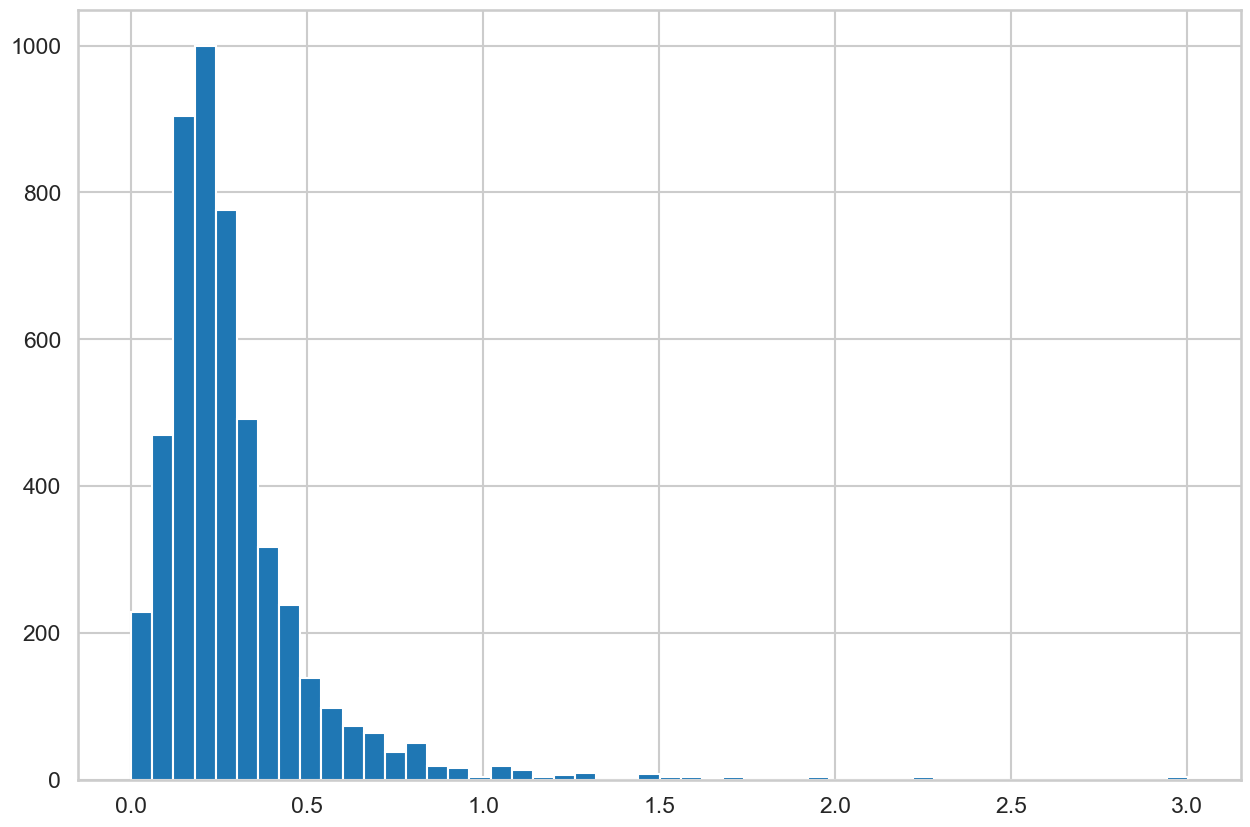

In [396]:
avg_dist_n_df['avg_dist_n'].hist(bins=50, figsize=(15,10))
plt.show()

In [397]:
avg_dist_n_df['avg_dist_n'].value_counts()

avg_dist_n
0.000000    94
0.137287    12
0.233029    10
0.059246    10
0.441992    10
            ..
0.221310     1
0.227285     1
0.636427     1
0.203950     1
0.364171     1
Name: count, Length: 1598, dtype: int64

In [398]:
from sklearn.utils import resample

In [399]:
def create_auto_strata_column(df, column_name, num_bins):
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    bin_edges = pd.cut(df_copy[column_name], bins=num_bins, retbins=True)[1]
    bin_labels = [f'Bin {i+1}' for i in range(len(bin_edges)-1)]
    df_copy[f'{column_name}_strata'] = pd.cut(df_copy[column_name], bins=bin_edges, labels=bin_labels, right=False)
    return df_copy

In [400]:
def upsample_minor_strata(df, column_name):
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    strata_counts = df_copy[column_name].value_counts()

    # Find the count of the majority stratum
    majority_count = strata_counts.max()

    # Create an empty DataFrame to store upsampled data
    upsampled_df = pd.DataFrame(columns=df_copy.columns)
    print(strata_counts.reset_index())
    strata_counts = strata_counts.reset_index().rename(columns={'index':column_name,column_name:'avg_dist_n_strata'})
    print(strata_counts)
    # Upsample each stratum to match the count of the majority stratum
    for stratum,count in zip(list(strata_counts.reset_index()[column_name]),list(strata_counts.reset_index()['avg_dist_n_strata'])):
        #print(f"stratum: {stratum} , count: {count}")
        #if count >= majority_count*0.20:
        stratum_df = df_copy[df_copy[column_name] == stratum]
        upsampled_stratum = resample(stratum_df, n_samples=majority_count, replace=True, random_state=42)
        upsampled_df = pd.concat([upsampled_df, upsampled_stratum])

    return upsampled_df

In [401]:
def remove_minor_strata(df, column_name):
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    strata_counts = df_copy[column_name].value_counts()

    # Find the count of the majority stratum
    majority_count = strata_counts.max()

    # Create an empty DataFrame to store upsampled data
    passed_df = pd.DataFrame(columns=df_copy.columns)
    strata_counts = strata_counts.reset_index().rename(columns={'index':column_name,column_name:'avg_dist_n_strata'})
    # Upsample each stratum to match the count of the majority stratum
    for stratum,count in zip(list(strata_counts.reset_index()[column_name]),list(strata_counts.reset_index()['avg_dist_n_strata'])):
        #print(f"stratum: {stratum} , count: {count}")
        if count >= majority_count*0.20:
            stratum_df = df_copy[df_copy[column_name] == stratum]
            passed_df = pd.concat([passed_df, stratum_df])
    return passed_df

In [402]:
df = create_auto_strata_column(df=avg_dist_n_df,column_name='avg_dist_n',num_bins=3)

In [403]:
df['avg_dist_n_strata'].value_counts()

avg_dist_n_strata
Bin 1    4918
Bin 2      76
Bin 3       3
Name: count, dtype: int64

In [404]:
df_upsampled  = upsample_minor_strata(df=df, column_name='avg_dist_n_strata')

  avg_dist_n_strata  count
0             Bin 1   4918
1             Bin 2     76
2             Bin 3      3
  avg_dist_n_strata  count
0             Bin 1   4918
1             Bin 2     76
2             Bin 3      3


In [405]:
df_upsampled['avg_dist_n_strata'].value_counts()

avg_dist_n_strata
Bin 1    4918
Bin 2    4918
Bin 3    4918
Name: count, dtype: int64

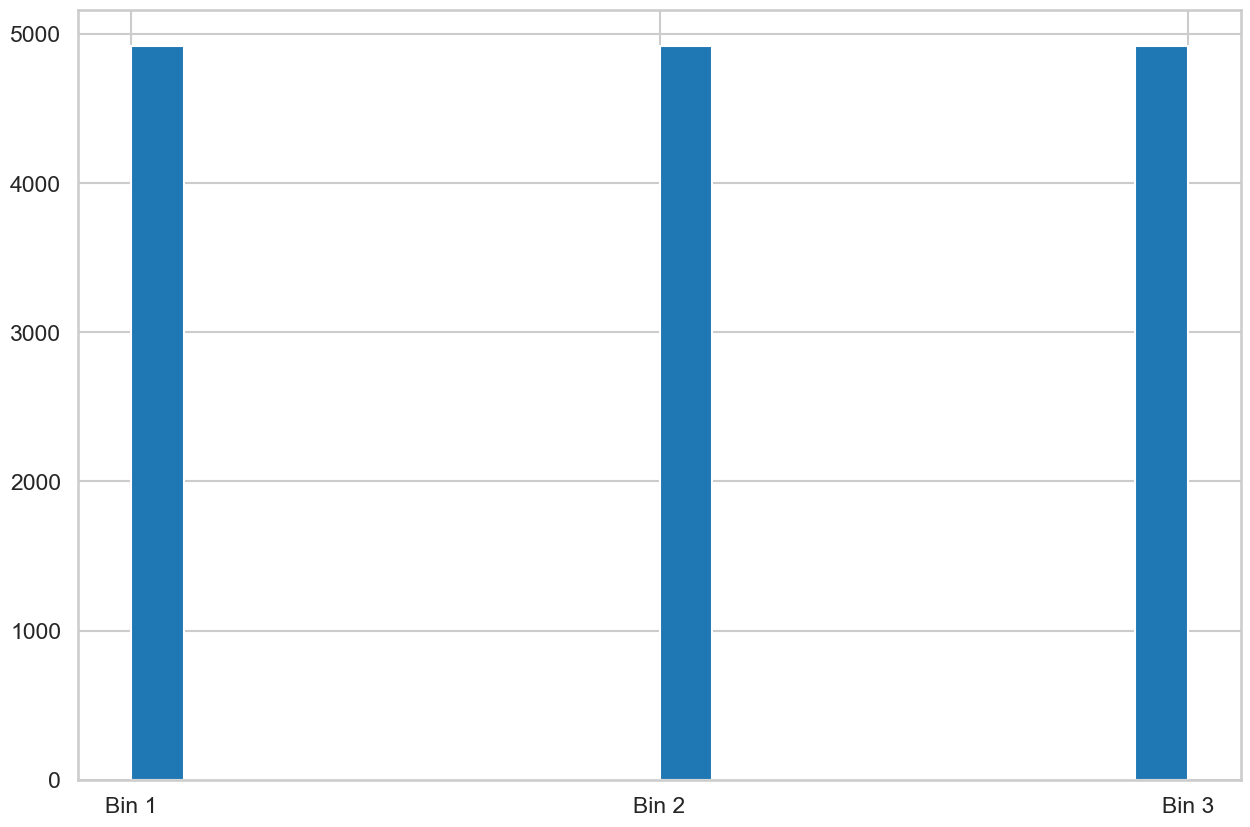

In [406]:
df_upsampled['avg_dist_n_strata'].hist(bins=20, figsize=(15,10))
plt.show()

In [407]:
def stratified_sample(avg_distances_df, groupby_column, sampling_rate):
    assert 0.0 < sampling_rate <= 1.0
    assert groupby_column in avg_distances_df.columns

    num_rows = int((avg_distances_df.shape[0] * sampling_rate))
    num_classes = len(avg_distances_df[groupby_column].unique())
    num_rows_per_class = int(max(1, ((num_rows / num_classes))))
    df_sample = avg_distances_df.groupby(groupby_column, group_keys=False).apply(lambda x: x.sample(min(len(x), num_rows_per_class)))

    return df_sample

In [408]:
df_strata = stratified_sample(avg_distances_df=df_upsampled, groupby_column='avg_dist_n_strata', sampling_rate=.8)

In [409]:
df_strata['avg_dist_n_strata'].value_counts()

avg_dist_n_strata
Bin 1    3934
Bin 2    3934
Bin 3    3934
Name: count, dtype: int64

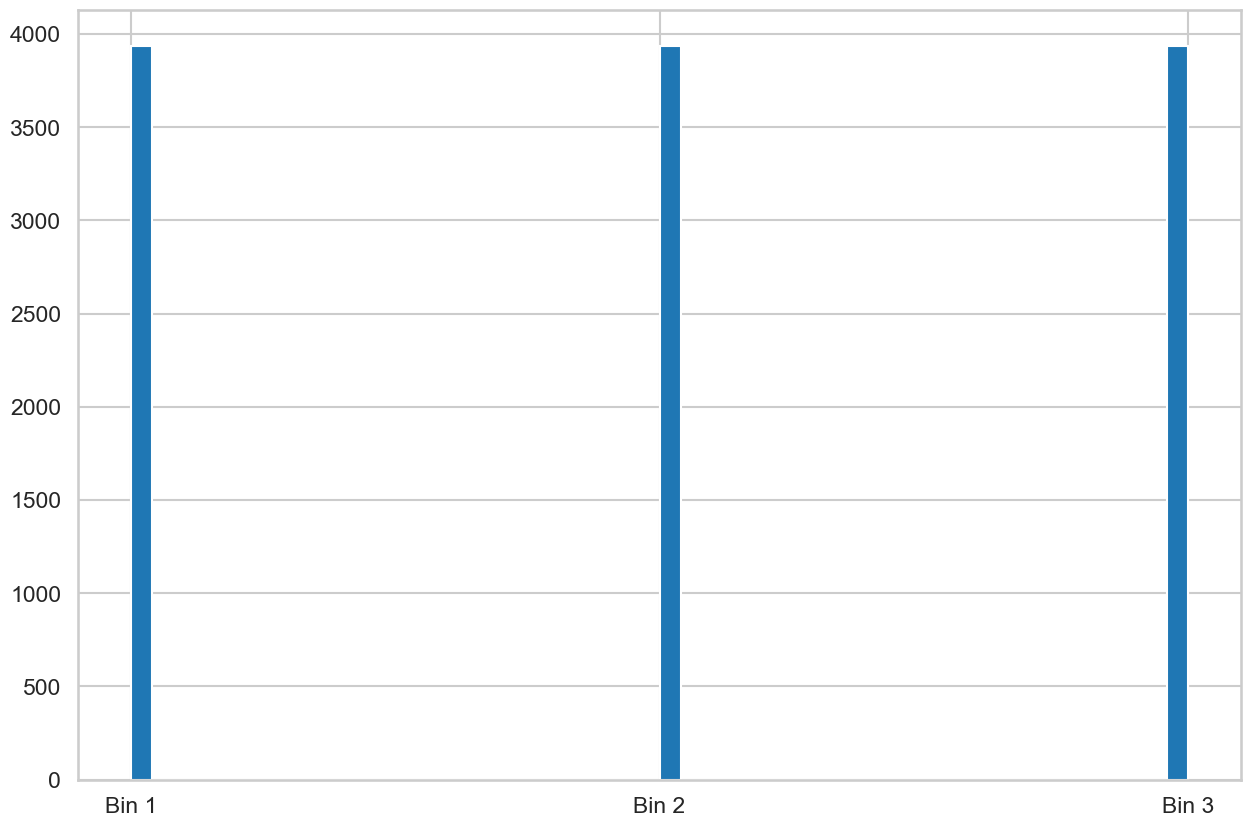

In [410]:
df_strata['avg_dist_n_strata'].hist(bins=50, figsize=(15,10))
plt.show()

(11802,)


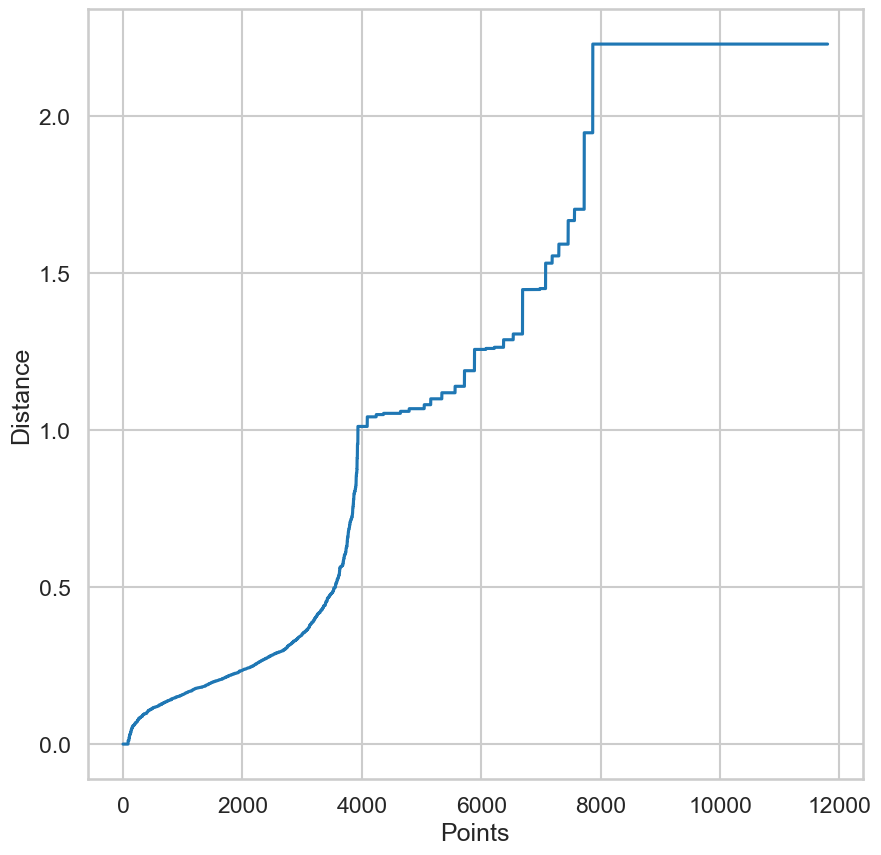

In [411]:
distances_strata = np.sort(df_strata['avg_dist_n'], axis=0)
print(distances_strata.shape)
i = np.arange(len(distances_strata))
knee_strata = KneeLocator(i, distances_strata, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(10, 10))
plt.plot(distances_strata)
plt.xlabel("Points")
plt.ylabel("Distance")

plt.savefig("Distance_curve.png", dpi=300)

2.23025097471584


<Figure size 2000x2000 with 0 Axes>

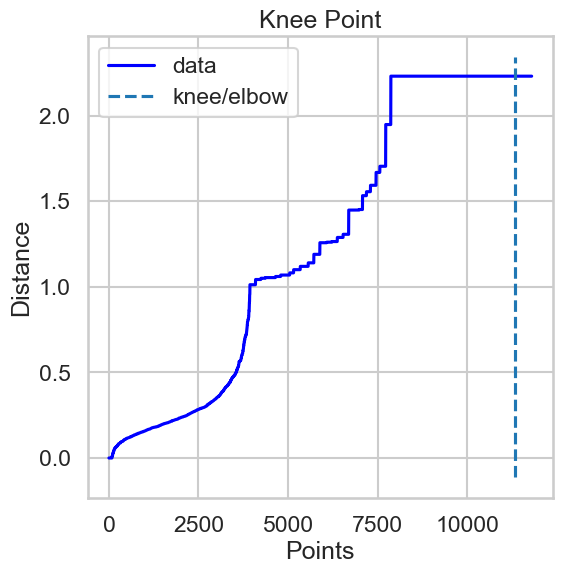

In [412]:
fig = plt.figure(figsize=(20, 20))
knee_strata.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("knee.png", dpi=300)
print(distances_strata[knee_strata.knee])

In [413]:
#Calculate Density Metrics
def calculate_density_metrics(df, eps):
    density_metrics = []
    
    for _, point in df.iterrows():
        # Count the number of points within eps distance of each point
        within_eps = df[df.apply(lambda x: np.linalg.norm(x - point) <= eps, axis=1)]
        density_metrics.append(len(within_eps))
    
    return density_metrics

#Compute the Standard Deviation
def compute_standard_deviation(density_metrics):
    return np.std(density_metrics)

# Setting the Range
def set_min_samples_range(average_density, std_dev):
    lower_bound = max(2, int(average_density - std_dev))
    upper_bound = int(average_density + std_dev)
    return lower_bound, upper_bound

In [414]:
#Calculate Density Metrics
eps = distances_strata[knee_strata.knee]
density_metrics = calculate_density_metrics(features_array_tsne_df_unlabeled, eps)

In [415]:
#Compute the Standard Deviation
std_dev = compute_standard_deviation(density_metrics)

In [416]:
#Setting the Range
average_density = np.mean(density_metrics)
lower_bound, upper_bound = set_min_samples_range(average_density, std_dev)

print(f"Average Density: {average_density}, Standard Deviation: {std_dev}")
print(f"Min Samples Range: {lower_bound} to {upper_bound}")

Average Density: 120.3772, Standard Deviation: 32.07117272816821
Min Samples Range: 88 to 152


In [417]:
#define the boundaries of search for min_sample: 
#QN: How to decide the boundary [similar to how to pick the random min_sample] {solved}
start_min_samples = lower_bound
end_min_samples = upper_bound

In [418]:
# find optimal min sample: method 1 - grid search
def find_optimal_min_samples(features_array_tsne, eps, start_min_samples, end_min_samples):
    since = time.time()
    best_min_samples = None
    best_silhouette_score = float('-inf')

    for i in np.arange(start_min_samples, end_min_samples, 1):
        db = DBSCAN(eps=eps, min_samples=int(i)).fit(features_array_tsne)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        if len(set(labels)) > 1:
            current_silhouette_score = silhouette_score(features_array_tsne, labels)
            print("For min_samples value =", int(i),
                  "Total no of clusters are :", len(set(labels)),
                  "Silhouette Score:", current_silhouette_score)

            if current_silhouette_score > best_silhouette_score:
                best_silhouette_score = current_silhouette_score
                best_min_samples = int(i)
        else:
            print("Insufficient clusters for min_samples value =", int(i))

    time_elapsed = time.time() - since
    print("Time taken for training: {:.0f}m : {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

    return best_min_samples

In [419]:
best_min_samples_grid_og = find_optimal_min_samples(features_array_pca_unlabeled,distances_strata[knee_strata.knee], start_min_samples, end_min_samples)
print("Best min_samples value:", best_min_samples_grid_og)

For min_samples value = 88 Total no of clusters are : 4 Silhouette Score: 0.5271567
For min_samples value = 89 Total no of clusters are : 4 Silhouette Score: 0.52778625
For min_samples value = 90 Total no of clusters are : 4 Silhouette Score: 0.52778625
For min_samples value = 91 Total no of clusters are : 4 Silhouette Score: 0.52545625
For min_samples value = 92 Total no of clusters are : 4 Silhouette Score: 0.52545625
For min_samples value = 93 Total no of clusters are : 4 Silhouette Score: 0.52545625
For min_samples value = 94 Total no of clusters are : 4 Silhouette Score: 0.52178067
For min_samples value = 95 Total no of clusters are : 4 Silhouette Score: 0.5212518
For min_samples value = 96 Total no of clusters are : 4 Silhouette Score: 0.5207504
For min_samples value = 97 Total no of clusters are : 4 Silhouette Score: 0.51998645
For min_samples value = 98 Total no of clusters are : 4 Silhouette Score: 0.51806927
For min_samples value = 99 Total no of clusters are : 4 Silhouette S

In [451]:
def find_optimal_min_samples(features_array_tsne, eps, start_min_samples, end_min_samples):
    since = time.time()
    best_min_samples = None
    best_silhouette_score = float('-inf')
    decrease_counter = 0
    last_silhouette_score = float('-inf')

    for i in np.arange(start_min_samples, end_min_samples, 1):
        db = DBSCAN(eps=eps, min_samples=int(i)).fit(features_array_tsne)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        if len(set(labels)) > 1:
            current_silhouette_score = silhouette_score(features_array_tsne, labels)
            print("For min_samples value =", int(i),
                  "Total no of clusters are :", len(set(labels)),
                  "Silhouette Score:", current_silhouette_score)

            if current_silhouette_score > best_silhouette_score:
                best_silhouette_score = current_silhouette_score
                best_min_samples = int(i)
                decrease_counter = 0  # Reset the counter when there is an improvement
            else:
                decrease_counter += 1  # Increment the counter when there is no improvement
                if decrease_counter >= 5:  # Check if there have been 5 consecutive decreases
                    break  # Exit the loop if the condition is met
            
            last_silhouette_score = current_silhouette_score  # Update the last silhouette score for comparison
        else:
            print("Insufficient clusters for min_samples value =", int(i))

    time_elapsed = time.time() - since
    print("Time taken for training: {:.0f}m : {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

    return best_min_samples

In [452]:
best_min_samples_grid_og = find_optimal_min_samples(features_array_pca_unlabeled,distances_strata[knee_strata.knee], start_min_samples, end_min_samples)
print("Best min_samples value:", best_min_samples_grid_og)

For min_samples value = 88 Total no of clusters are : 4 Silhouette Score: 0.5271567
For min_samples value = 89 Total no of clusters are : 4 Silhouette Score: 0.52778625
For min_samples value = 90 Total no of clusters are : 4 Silhouette Score: 0.52778625
For min_samples value = 91 Total no of clusters are : 4 Silhouette Score: 0.52545625
For min_samples value = 92 Total no of clusters are : 4 Silhouette Score: 0.52545625
For min_samples value = 93 Total no of clusters are : 4 Silhouette Score: 0.52545625
For min_samples value = 94 Total no of clusters are : 4 Silhouette Score: 0.52178067
Time taken for training: 0m : 2s
Best min_samples value: 89


In [422]:
db = DBSCAN(eps=distances_strata[knee_strata.knee], min_samples=best_min_samples_grid_og).fit(features_array_pca_unlabeled)
labels_strata = db.labels_

In [423]:
clusters,counts = np.unique( labels_strata, return_counts=True)

In [424]:
clusters

array([-1,  0,  1,  2])

In [425]:
counts

array([ 452, 1461, 2610,  477])

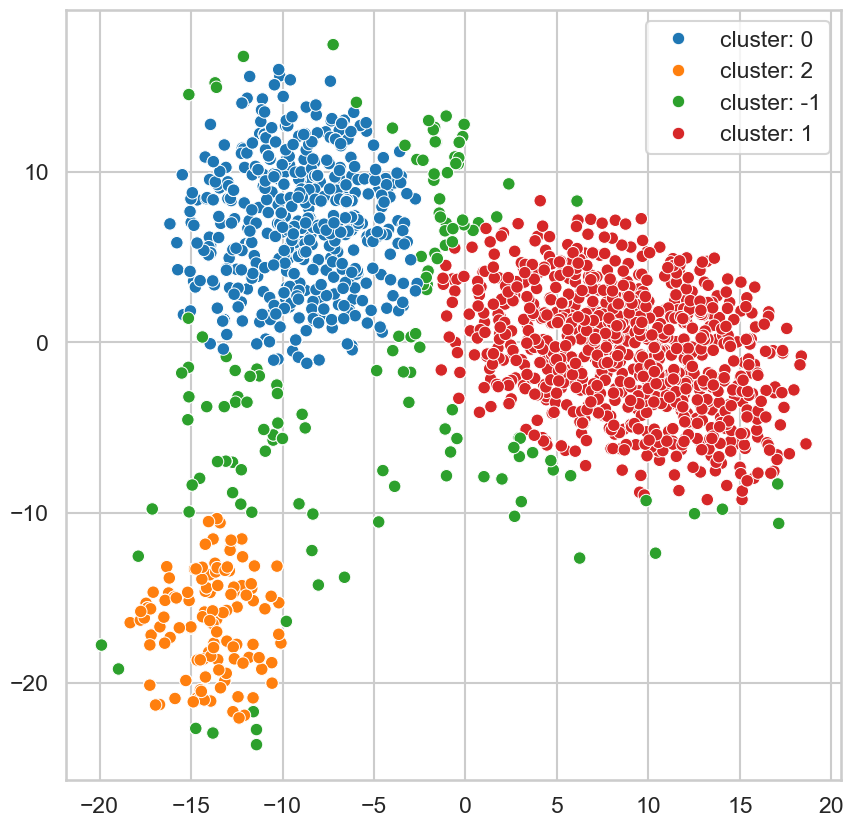

In [426]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=features_array_pca_unlabeled[:,0], y=features_array_pca_unlabeled[:,1], hue=["cluster: {}".format(x) for x in labels_strata])
plt.savefig("5k_no_2_ss_dbscan_with_knee.png", dpi=300)

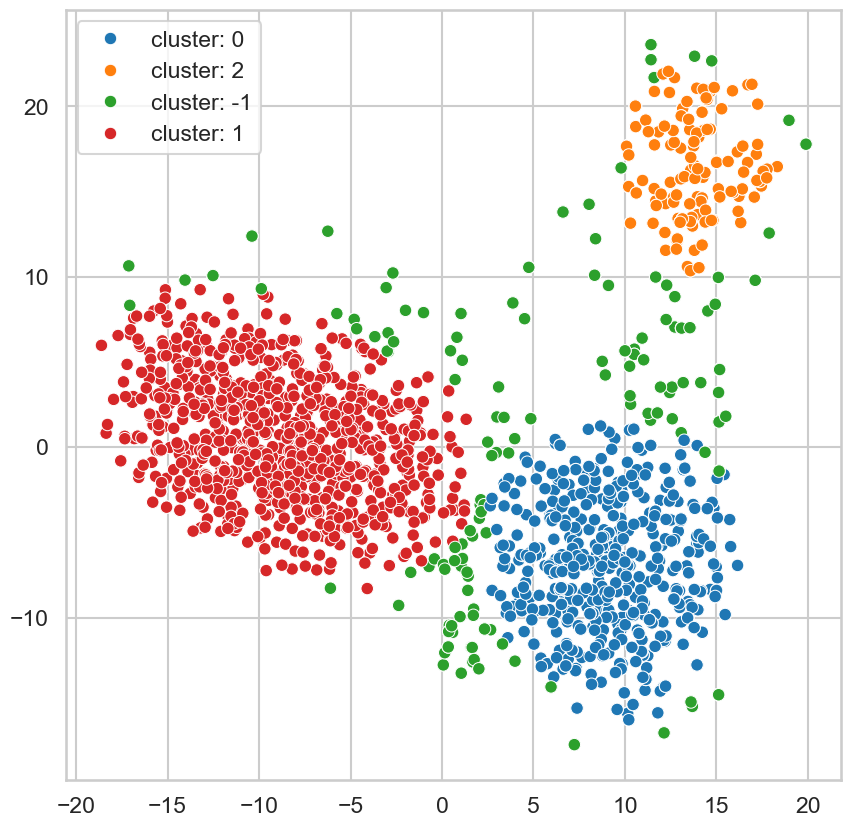

In [464]:
# This plot if flipped by 180 
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=-features_array_pca_unlabeled[:, 0],  # Flip X
    y=-features_array_pca_unlabeled[:, 1],  # Flip Y
    hue=["cluster: {}".format(x) for x in labels_strata]
)
plt.savefig("5k_no_2_ss_dbscan_with_knee_180rotated.png", dpi=300)


In [427]:
print(f"Silhouette Coefficient : Grid Search {silhouette_score(features_array_pca_unlabeled, labels_strata):.3f}")

Silhouette Coefficient : Grid Search 0.528


In [428]:
from sklearn.metrics import davies_bouldin_score

In [429]:
print(f"Davies-Bouldin index {davies_bouldin_score(features_array_pca_unlabeled, labels_strata):.3f}")

Davies-Bouldin index 1.356


### DBSCAN

In [430]:
distances[:,number_of_neighbors-1]# n - 1 (last index)

array([1.1061037 , 0.52586739, 0.17323839, ..., 1.55064076, 0.45317842,
       0.76147224])

(5000,)


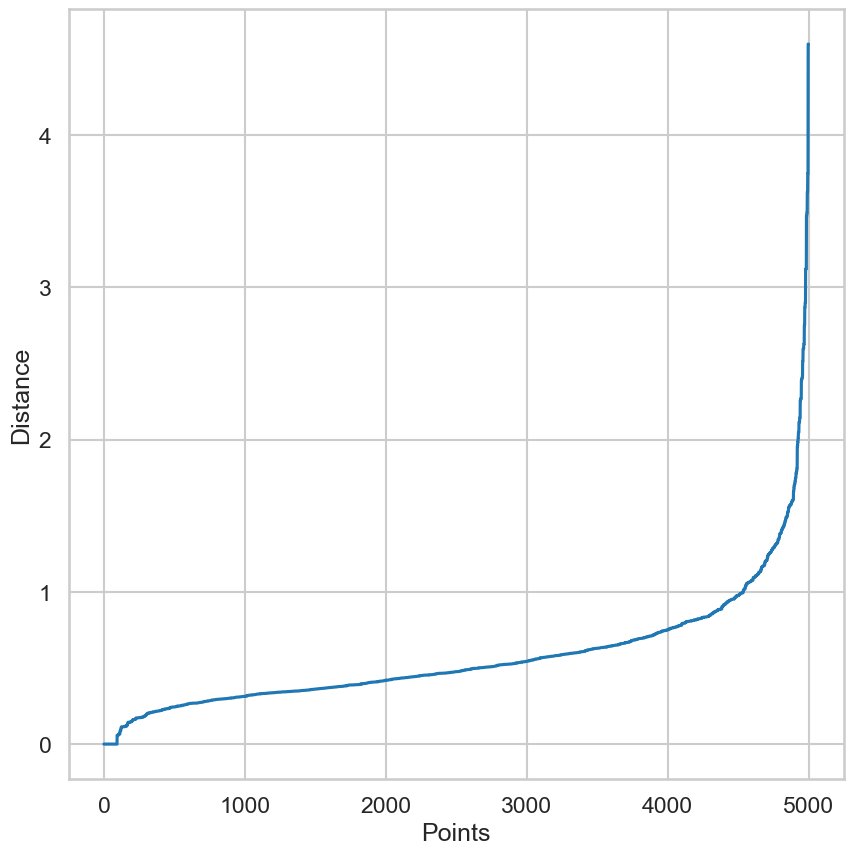

In [431]:
distances = np.sort(distances[:,number_of_neighbors-1], axis=0)
print(distances.shape)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(10, 10))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

plt.savefig("Distance_curve.png", dpi=300)

In [432]:
import seaborn

0.9250752443123184


<Figure size 2000x2000 with 0 Axes>

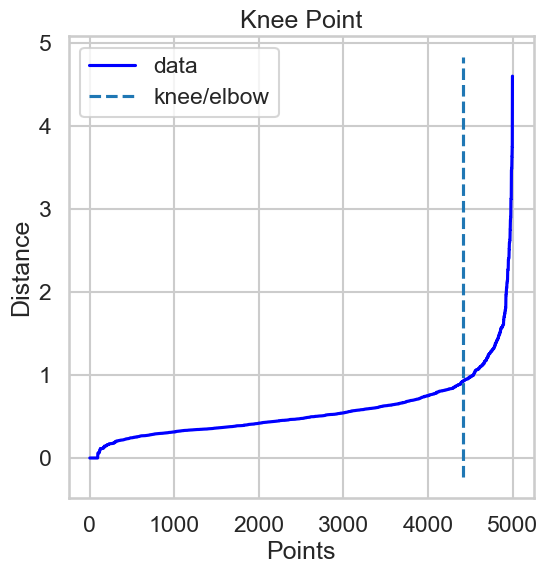

In [433]:
fig = plt.figure(figsize=(20, 20))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
seaborn.set_context("talk")
plt.savefig("knee.png", dpi=400)
print(distances[knee.knee])

In [434]:
db = DBSCAN(eps=distances[knee.knee], min_samples=4).fit(features_array_pca_unlabeled)
labels_dbsacan = db.labels_

In [435]:
# dbsacan = DBSCAN(min_samples=4, eps=0.01)
# dbsacan.fit(features_array_pca_unlabeled)
# labels_dbsacan = dbsacan.labels_

In [436]:
np.unique( labels_dbsacan, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55]),
 array([ 124,    6, 3932,   10,   11,   16,   36,   36,   17,   20,   18,
          16,    5,   15,    7,    8,    8,    4,   18,    9,    6,    6,
           6,    9,  374,   25,   10,    4,   24,    5,    4,    4,   13,
           5,   12,   10,    4,    5,    5,    5,    7,    4,    6,   21,
          14,    9,    6,    9,   14,    5,    6,    9,    5,   15,    6,
           6,    6]))

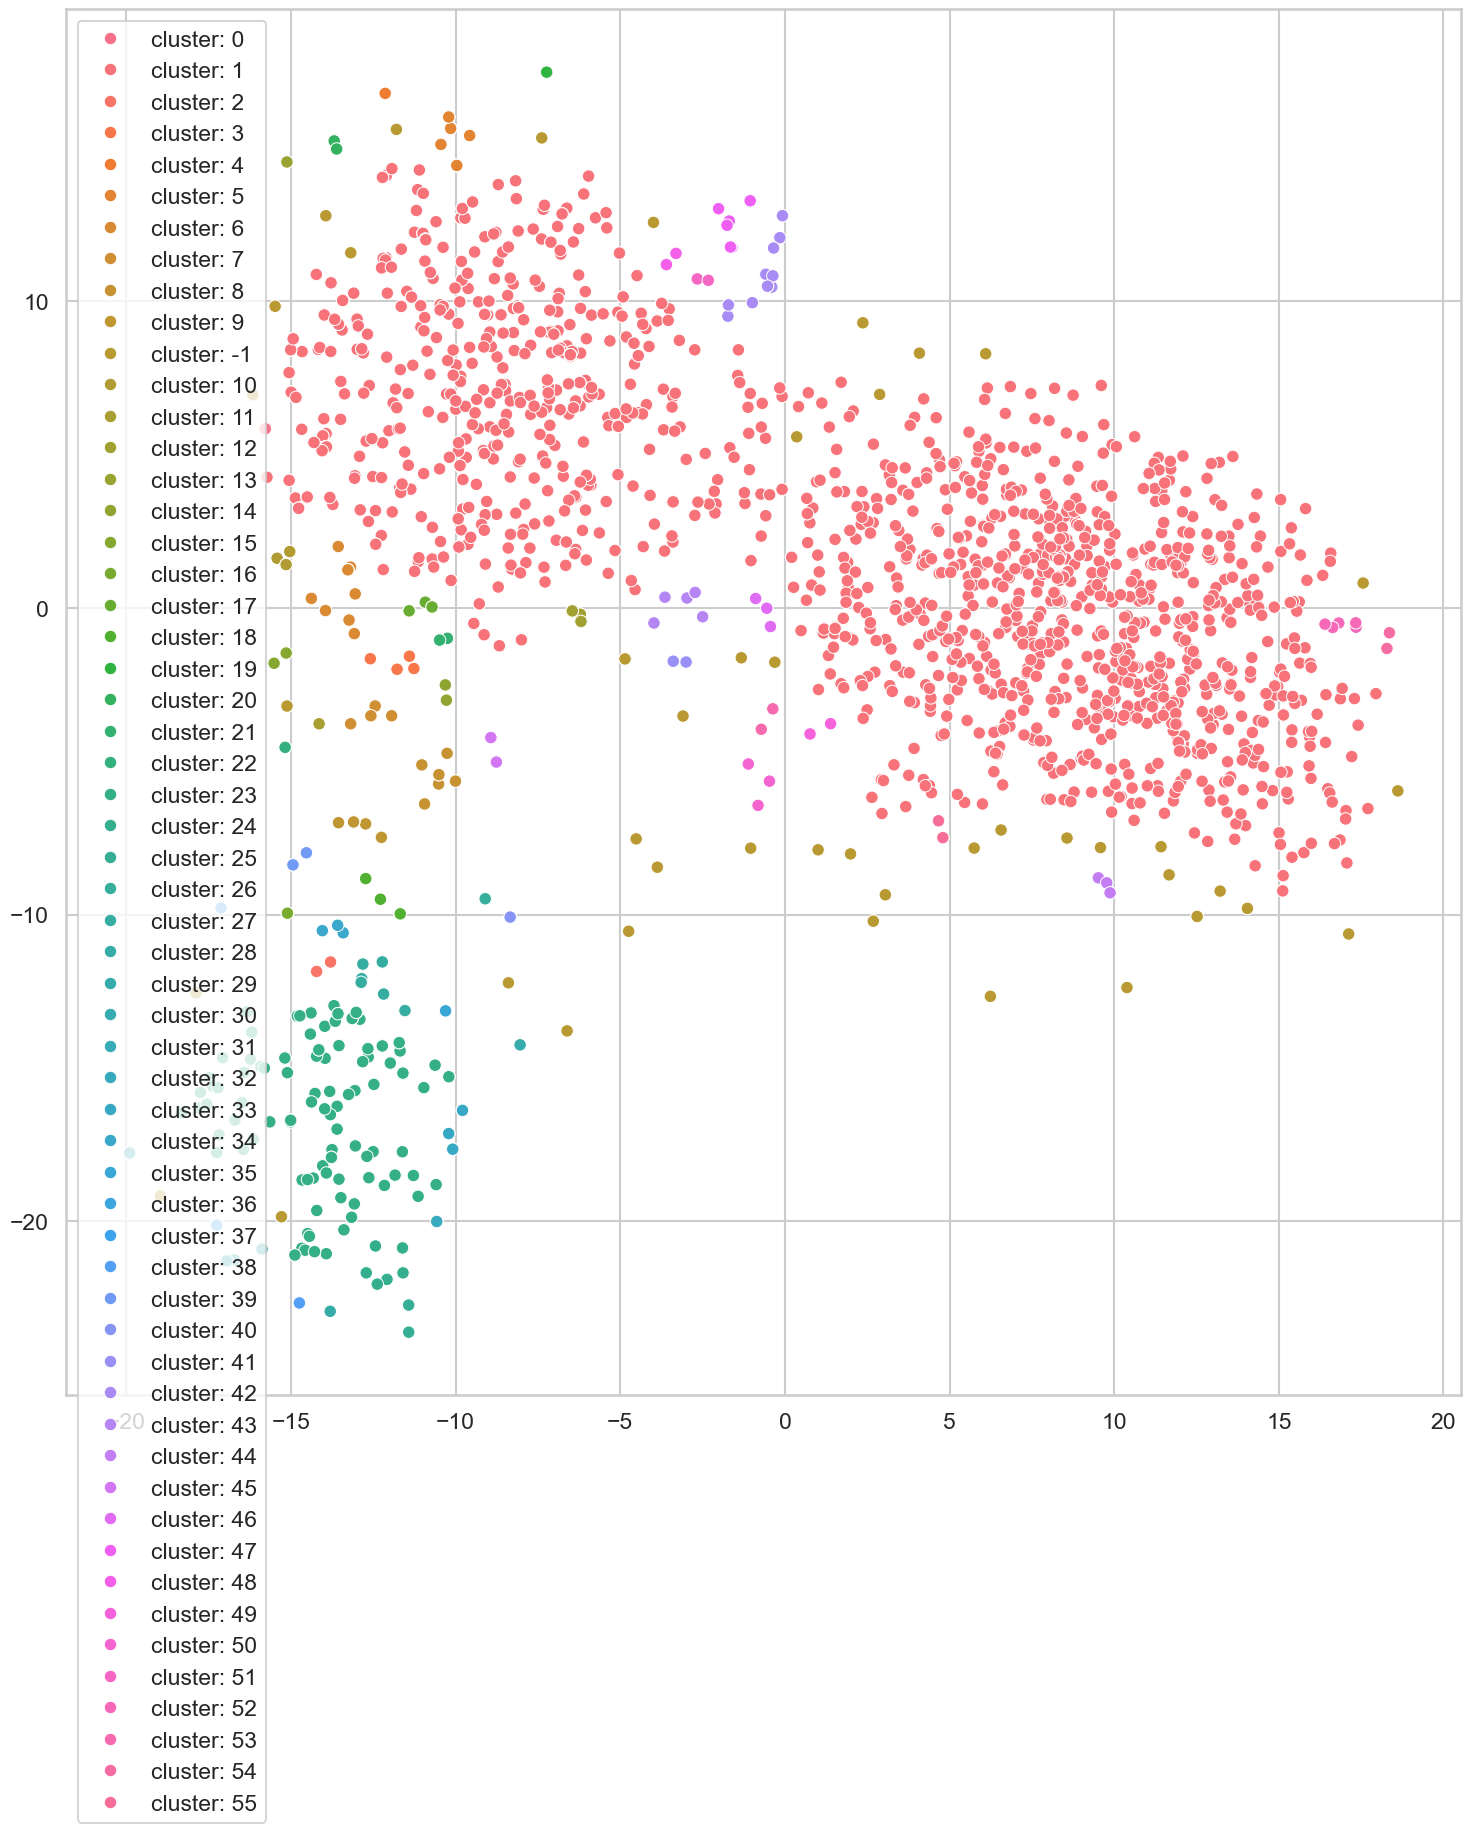

In [437]:
fig = plt.figure(figsize=(18, 18))
sns.scatterplot(x=features_array_pca_unlabeled[:,0], y=features_array_pca_unlabeled[:,1], hue=["cluster: {}".format(x) for x in labels_dbsacan])
plt.savefig("5k_no_2_dbscan.png", dpi=300)

In [458]:
print(f"Silhouette Coefficient :DBSAN {silhouette_score(features_array_pca_unlabeled, labels_dbsacan):.2f}")

Silhouette Coefficient :DBSAN -0.41


In [461]:
print(f"Davies-Bouldin index {davies_bouldin_score(features_array_pca_unlabeled, labels_dbsacan):.3f}")

Davies-Bouldin index 1.977


### HDBSCAN

In [439]:
#HDBSCAN
hdb = HDBSCAN(min_cluster_size=20, min_samples=15, alpha=1.3)
hdb.fit(features_array_pca_unlabeled)
labels_hdb = hdb.labels_

In [440]:
np.unique( labels_hdb, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21]),
 array([1098,  499,   38,   34,   39,   22,   44,   36,   24, 2348,   70,
          37,   21,   85,   24,   28,   26,   26,   31,   22,   67,  340,
          41]))

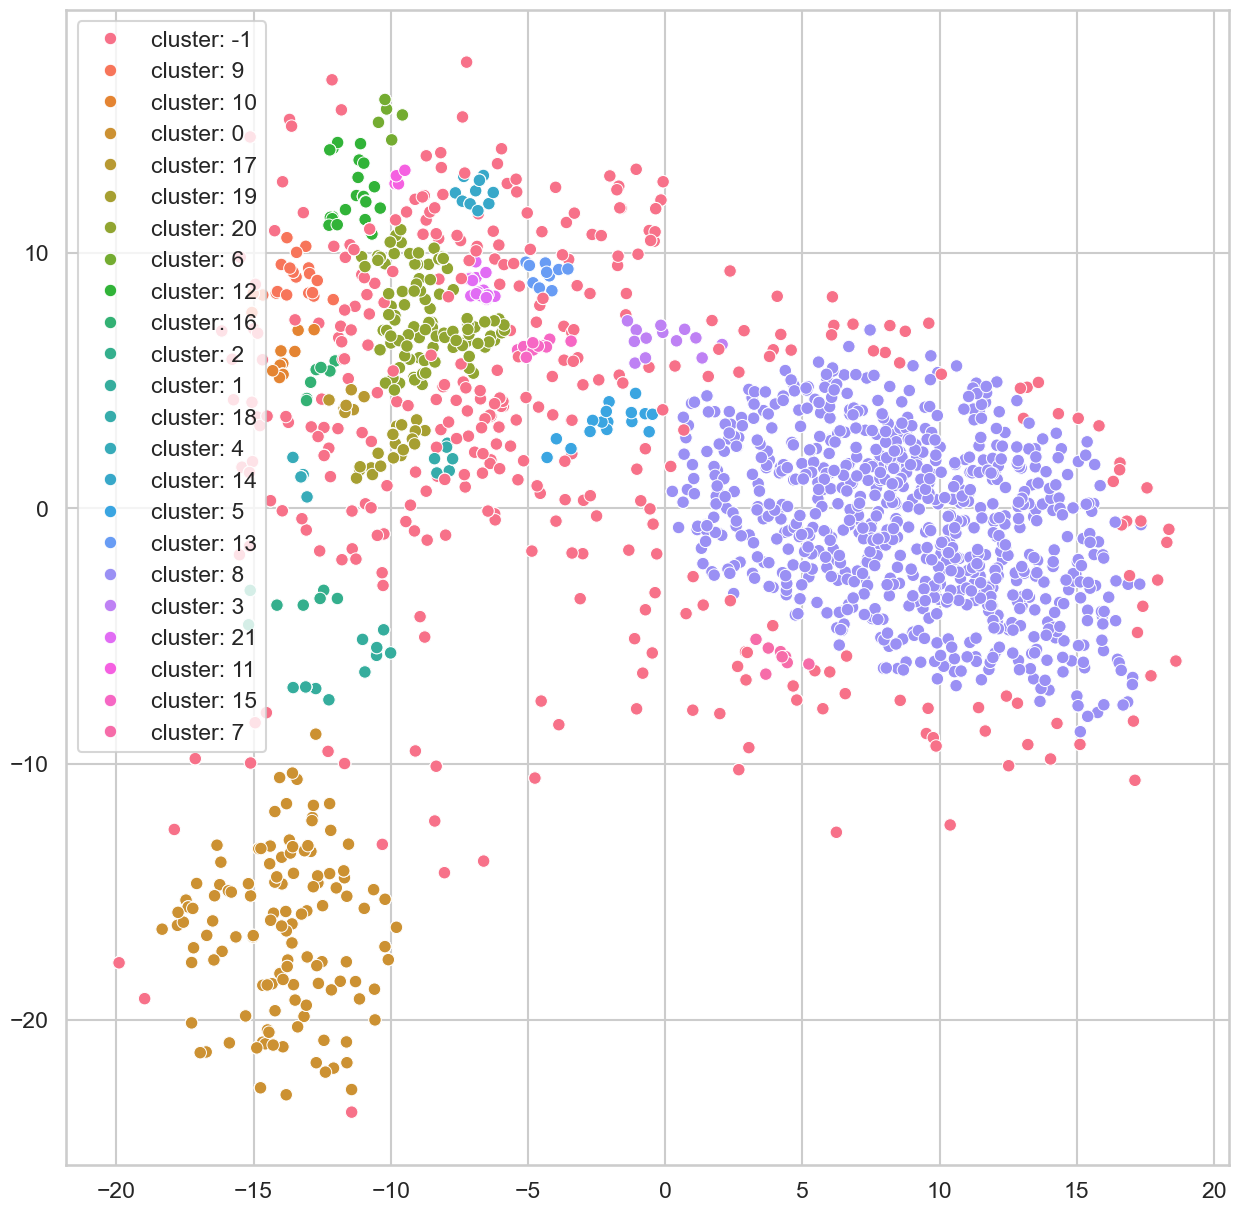

In [441]:
fig = plt.figure(figsize=(15, 15))
sns.scatterplot(x=features_array_pca_unlabeled[:,0], y=features_array_pca_unlabeled[:,1], hue=["cluster: {}".format(x) for x in labels_hdb])
plt.savefig("5k_no_2_hdbscan.png", dpi=300)

In [442]:
print(f"Silhouette Coefficient : Vanilla DBSAN {silhouette_score(features_array_pca_unlabeled, labels_hdb):.2f}")

Silhouette Coefficient : Vanilla DBSAN 0.02


In [462]:
print(f"Davies-Bouldin index {davies_bouldin_score(features_array_pca_unlabeled, labels_hdb):.3f}")

Davies-Bouldin index 1.646


OPTICS

In [443]:
from sklearn.cluster import OPTICS

In [444]:
# Fit the OPTICS model
clustering = OPTICS(min_samples=7, xi=0.001,min_cluster_size=.05,metric='l2')
clustering.fit(features_array_pca_unlabeled)

OPTICS(metric='l2', min_cluster_size=0.05, min_samples=7, xi=0.001)

In [445]:
 # Extract the clusters
optics_labels = clustering.labels_

In [446]:
# Print the cluster labels
print("Cluster Labels:", optics_labels)

Cluster Labels: [-1 -1 -1 ... -1  3 -1]


In [447]:
cluster_labels = pd.DataFrame(data=optics_labels,columns=['cluster_labels'])

In [448]:
cluster_labels.value_counts()

cluster_labels
-1                3906
 3                 309
 2                 272
 1                 260
 0                 253
Name: count, dtype: int64

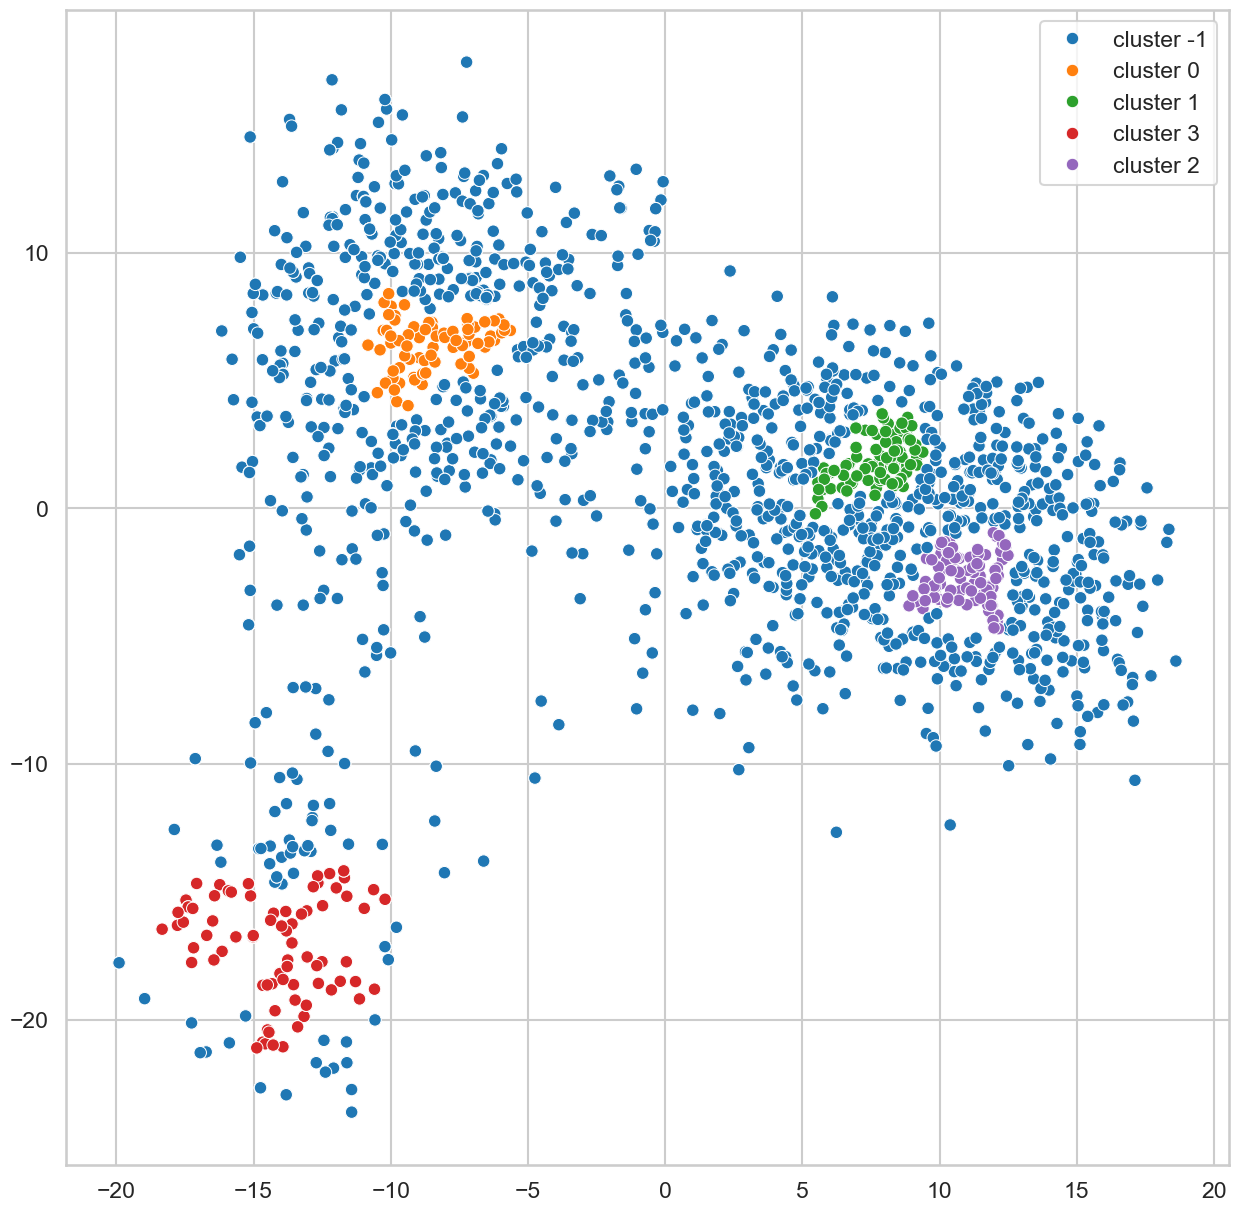

In [449]:
fig = plt.figure(figsize=(15, 15))
sns.scatterplot(x=features_array_pca_unlabeled[:, 0], y=features_array_pca_unlabeled[:, 1], hue=["cluster {}".format(x) for x in optics_labels])
plt.savefig("mimic_optics.png", dpi=300)

In [450]:
print(f"Silhouette Coefficient : OPTICS {silhouette_score(features_array_pca_unlabeled, optics_labels):.2f}")

Silhouette Coefficient : OPTICS -0.33


In [463]:
print(f"Davies-Bouldin index {davies_bouldin_score(features_array_pca_unlabeled, optics_labels):.3f}")

Davies-Bouldin index 1.263
